In [1]:
from huggingface_hub import login
huggingface_token=""
login(token=huggingface_token)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [2]:
%env TOKENIZERS_PARALLELISM = false

env: TOKENIZERS_PARALLELISM=false


In [3]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, get_linear_schedule_with_warmup

In [5]:
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

'<|endoftext|>'

In [6]:
tokenizer.encode_plus('hello! this is a caption')

{'input_ids': [31373, 0, 428, 318, 257, 8305], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.optim as optim
import os
import csv
import json
import numpy as np
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [9]:
sample_tfms = [
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.ColorJitter(),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=45, p=0.5),
    A.HueSaturationValue(p=0.3),
]
train_tfms = A.Compose([
    *sample_tfms,
    A.Resize(224,224),
    A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),
    ToTensorV2()
])
valid_tfms = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),
    ToTensorV2()
])

In [10]:
class TrainData(Dataset):
    def __init__(self, img_path, caption_path,tfms):
        # self.img_folder=image_path
        file_list = os.listdir(img_path)
        file_list = sorted(file_list, key=lambda x: int(x[6:-4]))
        self.image_path = []
        for file in file_list:
          path=os.path.join(img_path,file)
          self.image_path.append(path)

        self.captions=[]
        with open(caption_path, mode='r') as file:
          reader = csv.reader(file)
          for row in reader:
            self.captions.append(row)
        self.captions=self.captions[1:]
        self.captions=[arr[2] for arr in self.captions]
        # self.captions=self.captions[:10]
        self.tfms = tfms

    def __len__(self):
      return len(self.captions)

    def __getitem__(self, idx):
        img_name=self.image_path[idx]
        input_image = Image.open(img_name)
        image = input_image.convert('RGB')
        image = np.array(image)
        augs = self.tfms(image=image)
        image = augs['image']

        caption = f"{self.captions[idx]} <|endoftext|>"
        print(len(caption.split()))
        input_ids = tokenizer(caption,truncation=True)['input_ids']
        labels = input_ids.copy()
        labels[:-1] = input_ids[1:]
        return image,input_ids,labels

In [11]:
class ValData(Dataset):
    def __init__(self, img_path, caption_path,tfms):
        # self.img_folder=image_path
        file_list = os.listdir(img_path)
        print(file_list)
        file_list = sorted(file_list, key=lambda x: int(x[4:-4]))
        self.image_path = []
        for file in file_list:
          path=os.path.join(img_path,file)
          self.image_path.append(path)

        self.captions=[]
        with open(caption_path, mode='r') as file:
          reader = csv.reader(file)
          for row in reader:
            self.captions.append(row)
        self.captions=self.captions[1:]
        self.captions=[arr[2] for arr in self.captions]
        # self.captions=self.captions[:10]
        self.tfms = tfms

    def __len__(self):
      return len(self.captions)

    def __getitem__(self, idx):
        img_name=self.image_path[idx]
        input_image = Image.open(img_name)
        image = input_image.convert('RGB')
        image = np.array(image)
        augs = self.tfms(image=image)
        image = augs['image']

        caption = f"{self.captions[idx]} <|endoftext|>"
        print(len(caption.split()))
        input_ids = tokenizer(caption,truncation=True)['input_ids']
        labels = input_ids.copy()
        labels[:-1] = input_ids[1:]
        return image,input_ids,labels

In [12]:
def collate_fn(batch):
    image = [i[0] for i in batch]
    input_ids = [i[1] for i in batch]
    labels = [i[2] for i in batch]
    image = torch.stack(image,dim=0)
    input_ids = tokenizer.pad(
        {'input_ids':input_ids},
        padding='longest',
        return_attention_mask=False,
        return_tensors='pt'
    )['input_ids']
    labels = tokenizer.pad(
        {'input_ids':labels},
        padding='longest',
        return_attention_mask=False,
        return_tensors='pt'
    )['input_ids']
    mask = (input_ids!=tokenizer.pad_token_id).long()
    labels[mask==0]=-100
    return image, input_ids, labels

In [13]:
arr=[1,2,3,4,5,6,7,8,9,10]
labels = arr.copy()
labels[:-1] = arr[1:]
labels

[2, 3, 4, 5, 6, 7, 8, 9, 10, 10]

In [14]:
import zipfile
zip_file_path=r"/content/drive/MyDrive/Colab Notebooks/Data/IC_dataset/train.zip"
extract_to="/content/drive/MyDrive/Colab Notebooks/Data/IC_dataset"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents of the zip file to the specified directory
    zip_ref.extractall(extract_to)

In [15]:
zip_file_path=r"/content/drive/MyDrive/Colab Notebooks/Data/IC_dataset/val.zip"
extract_to="/content/drive/MyDrive/Colab Notebooks/Data/IC_dataset"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents of the zip file to the specified directory
    zip_ref.extractall(extract_to)

In [ ]:

train_caption_path="/content/drive/MyDrive/Colab Notebooks/Data/IC_dataset/train.csv"
train_img_path=r"/content/drive/MyDrive/Colab Notebooks/Data/IC_dataset/train"
train_data = TrainData(train_img_path,train_caption_path,train_tfms)
# train_data.__len__()
# train_data.__getitem__(0)['labels'].shape
# dl = DataLoader(train_data,shuffle=True,batch_size=2,custom_collate=collate_fn)
# for i,batch in enumerate(dl):
  # print(i ,"  shapes :- ",batch['image'].shape," ",batch['input_tokens'].shape," ",batch['labels'].shape)
  # output_list = batch['feature'][0].tolist()
val_caption_path="/content/drive/MyDrive/Colab Notebooks/Data/IC_dataset/val.csv"
val_img_path = "/content/drive/MyDrive/Colab Notebooks/Data/IC_dataset/val"

val_data = ValData(val_img_path,val_caption_path,valid_tfms)
# train_data.__len__()

In [17]:
train_data.__len__()

5715

In [18]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from timm import create_model, list_models
from types import SimpleNamespace
from pathlib import Path
from torch.cuda.amp import GradScaler, autocast
from tqdm.auto import tqdm
import gc

In [20]:
class GPT2Attention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension by be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len

        self.c_attn = nn.Linear(self.embed_dim, self.head_size * self.n_heads * 3,bias=True)
        self.scale = self.head_size ** -0.5

        self.register_buffer('mask',torch.tril(torch.ones(1,1,self.seq_len,self.seq_len)))

        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)

        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)


    def forward(self, x):
        b,t,c = x.shape
        # q,k,v shape individually: batch_size x seq_len x embed_dim
        # we know that qk_t = q x k_t, where q=bxtxhead_dim, k_t=bxhead_timxt
        q,k,v = self.c_attn(x).chunk(3,dim=-1)
        q = q.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3) # batch x n_heads x seq_len x head_dim
        k = k.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)

        qk_t = (q@k.transpose(-2,-1)) * self.scale
        qk_t = qk_t.masked_fill(self.mask[:,:,:t,:t]==0,float('-inf'))
        qk_t = F.softmax(qk_t,dim=-1)
        weights = self.attn_dropout(qk_t)

        attention = weights @ v # batch x n_heads x t x head_size
        attention = attention.permute(0,2,1,3).contiguous().view(b,t,c) # batch x t x embed_dim

        out = self.c_proj(attention)
        out = self.resid_dropout(out)

        return out

In [21]:
class GPT2CrossAttention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension by be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len

        self.q = nn.Linear(self.embed_dim,self.embed_dim)
        self.k = nn.Linear(self.embed_dim,self.embed_dim)
        self.v = nn.Linear(self.embed_dim,self.embed_dim)
        self.scale = self.head_size ** -0.5

        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)

        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)


    def forward(self, q,k,v):
        b,t,c = q.shape

        q = self.q(q)
        k = self.k(k)
        v = self.v(v)

        q = q.view(b,q.size(1),self.n_heads,self.head_size).permute(0,2,1,3) # batch x n_heads x seq_len x head_dim
        k = k.view(b,k.size(1),self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,v.size(1),self.n_heads,self.head_size).permute(0,2,1,3)

        qk_t = (q@k.transpose(-2,-1)) * self.scale
        qk_t = F.softmax(qk_t,dim=-1)
        weights = self.attn_dropout(qk_t)

        attention = weights @ v # batch x n_heads x t x head_size
        attention = attention.permute(0,2,1,3).contiguous().view(b,t,c) # batch x t x embed_dim

        out = self.c_proj(attention)
        out = self.resid_dropout(out)

        return out

In [22]:
class GPT2MLP(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.mlp_ratio = config.mlp_ratio
        self.mlp_dropout = config.mlp_dropout

        self.c_fc = nn.Linear(self.embed_dim,self.embed_dim*self.mlp_ratio)
        self.c_proj = nn.Linear(self.embed_dim*self.mlp_ratio,self.embed_dim)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(self.mlp_dropout)

    def forward(self,x):
        x = self.c_fc(x)
        x = self.act(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

In [23]:
class GPT2Block(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.ln_1 = nn.LayerNorm(self.embed_dim)
        self.attn = GPT2Attention(config)
        self.ln_2 = nn.LayerNorm(self.embed_dim)
        self.mlp = GPT2MLP(config)
        self.ln_3 = nn.LayerNorm(self.embed_dim)
        self.cross_attn = GPT2CrossAttention(config)

    def forward(self,x,enc_out):
        x = x+self.attn(self.ln_1(x))
        x = x+self.cross_attn(self.ln_2(x),enc_out,enc_out)
        x = x+self.mlp(self.ln_3(x))
        return x

In [24]:
class VisionGPT2Model(nn.Module):
    def __init__(self,config):
        super().__init__()

        self.config = config

        vit = create_model('vit_base_patch16_224',pretrained=True,num_classes=0)
        self.patch_embed = vit.patch_embed
        num_patches = self.patch_embed.num_patches

        self.cls_token = vit.cls_token
        embed_len = num_patches + vit.num_prefix_tokens
        self.pos_embed = vit.pos_embed
        self.pos_drop = nn.Dropout(p=0.)

        self.blocks = nn.ModuleList([vit.blocks[i] for i in range(config.depth)])

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size,config.embed_dim),
            wpe = nn.Embedding(config.seq_len,config.embed_dim),
            drop = nn.Dropout(config.emb_dropout),
            h = nn.ModuleList([GPT2Block(config) for _ in range(config.depth)]),
            ln_f = nn.LayerNorm(config.embed_dim)
        ))
        self.lm_head = nn.Linear(config.embed_dim,config.vocab_size,bias=False)
        self.transformer.wte.weight = self.lm_head.weight

    def _pos_embed(self,x):
        pos_embed = self.pos_embed
        x = torch.cat((self.cls_token.expand(x.shape[0], -1, -1), x), dim=1)
        x = x + pos_embed
        return self.pos_drop(x)

    def pretrained_layers_trainable(self,trainable=False):
        layers = [
            self.cls_token, self.patch_embed, self.pos_embed, self.blocks,
            self.transformer.wte, self.transformer.wpe,
            self.transformer.ln_f, self.lm_head
        ]
        gpt_layers = [[
            self.transformer.h[i].ln_1,self.transformer.h[i].ln_2,
            self.transformer.h[i].attn,self.transformer.h[i].mlp
        ] for i in range(self.config.depth)]
        for l in gpt_layers:
            layers.extend(l)

        for layer in layers:
            if not isinstance(layer,nn.Parameter):
                for p in layer.parameters():
                    p.requires_grad = trainable
            else:
                layer.requires_grad = trainable

        total_frozen_params = sum([p.numel() for p in self.parameters() if not p.requires_grad])
        print(f'{total_frozen_params=}')

    def unfreeze_gpt_layers(self,):
        gpt_layers = [[
            self.transformer.h[i].ln_1,self.transformer.h[i].ln_2,
            self.transformer.h[i].attn,self.transformer.h[i].mlp
        ] for i in range(self.config.depth)]
        flatten = []
        for l in gpt_layers:
            flatten.extend(l)

        for layer in flatten:
            if not isinstance(layer,nn.Parameter):
                for p in layer.parameters():
                    p.requires_grad = True
            else:
                layer.requires_grad = True

    @classmethod
    def from_pretrained(self,config):
        model = VisionGPT2Model(config)
        sd = model.state_dict()
        keys = sd.keys()
        ignore_matches = ['blocks.','cross_attn.','ln_3','cls_token','pos_embed','patch_embed.','.attn.mask']
        vit_keys = [key for key in keys if any(match in key for match in ignore_matches)]
        gpt_keys = [key for key in keys if key not in vit_keys]

        gpt2_small = GPT2LMHeadModel.from_pretrained('gpt2')
        sd_hf = gpt2_small.state_dict()
        hf_keys = sd_hf.keys()
        hf_keys = [k for k in hf_keys if not k.endswith('.attn.masked_bias')]
        hf_keys = [k for k in hf_keys if not k.endswith('.attn.bias')]
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']

        for k in hf_keys:
            if any(match in k for match in ignore_matches):
                continue
            if any(k.endswith(w) for w in transposed):
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        model.load_state_dict(sd)

        return model

    def forward(self,image,input_ids,labels=None):

        image = self.patch_embed(image)
        image = self._pos_embed(image)

        token_embeddings = self.transformer.wte(input_ids) # batch x seq_len
        pos_embs = torch.arange(0,input_ids.size(1)).to(input_ids.device)
        positional_embeddings = self.transformer.wpe(pos_embs)
        input_ids = self.transformer.drop(token_embeddings+positional_embeddings)

        for i in range(self.config.depth):
            image = self.blocks[i](image)
            input_ids = self.transformer.h[i](input_ids, image)

        input_ids = self.transformer.ln_f(input_ids)

        if labels is not None:
            lm_logits = self.lm_head(input_ids)
            loss = F.cross_entropy(lm_logits.view(-1, lm_logits.shape[-1]), labels.view(-1))
            return loss

        lm_logits = self.lm_head(input_ids[:,[-1],:])
        return lm_logits

    def generate(self,image,sequence,max_tokens=50,temperature=1.0,deterministic=False):
        for _ in range(max_tokens):
            out = self(image,sequence)
            out = out[:,-1,:] / temperature
            probs = F.softmax(out,dim=-1)
            if deterministic:
                next_token = torch.argmax(probs,dim=-1,keepdim=True)
            else:
                next_token = torch.multinomial(probs,num_samples=1)
            sequence = torch.cat([sequence,next_token],dim=1)
            if next_token.item() == tokenizer.eos_token_id:
                break

        return sequence.cpu().flatten()

In [25]:
class Trainer:
    def __init__(self,model_config,train_config, dls):

        self.train_config = train_config
        self.model_config = model_config
        self.device = self.train_config.device

        self.model = VisionGPT2Model.from_pretrained(model_config).to(self.device)
        self.model.pretrained_layers_trainable(trainable=False)

        print(f'trainable parameters: {sum([p.numel() for p in self.model.parameters() if p.requires_grad])}')

        self.tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
        self.tokenizer.pad_token = self.tokenizer.eos_token

        self.scaler = GradScaler()

        self.train_dl, self.val_dl = dls

        total_steps = len(self.train_dl)

        self.optim = torch.optim.Adam(self.model.parameters(), lr=self.train_config.lr / 25.)
        self.sched = torch.optim.lr_scheduler.OneCycleLR(
            self.optim,
            max_lr=self.train_config.lr,
            epochs=self.train_config.epochs,
            steps_per_epoch=total_steps
        )

#         self.sched = get_linear_schedule_with_warmup(self.optim,num_warmup_steps=0,num_training_steps=total_steps)

        self.metrics = pd.DataFrame()
        self.metrics[['train_loss','train_perplexity','val_loss','val_perplexity']] = None

        self.gen_tfms = A.Compose([
            A.Resize(224,224),
            A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),
            ToTensorV2()
        ])


    def save_model(self,):
        self.train_config.model_path.mkdir(exist_ok=True)
        sd = self.model.state_dict()
        torch.save(sd,"/content/drive/MyDrive/Colab Notebooks/Data/IC_dataset/trained_model_B.pth")
        torch.save(sd,self.train_config.model_path/'captioner.pt')



    def load_best_model(self,):
        sd = torch.load(self.train_config.model_path/'captioner.pt')
        self.model.load_state_dict(sd)


    def train_one_epoch(self,epoch):

        prog = tqdm(self.train_dl,total=len(self.train_dl))

        running_loss = 0.

        for image, input_ids, labels in prog:

            with autocast():
                image = image.to(self.device)
                input_ids = input_ids.to(self.device)
                labels = labels.to(self.device)

                loss = self.model(image,input_ids,labels)

                self.scaler.scale(loss).backward()
                self.scaler.step(self.optim)
                self.scaler.update()
                self.sched.step()
                self.optim.zero_grad(set_to_none=True)

                running_loss += loss.item()

                prog.set_description(f'train loss: {loss.item():.3f}')

            del image, input_ids, labels, loss

        train_loss = running_loss / len(self.train_dl)
        train_pxp = np.exp(train_loss)

        self.metrics.loc[epoch,['train_loss','train_perplexity']] = (train_loss,train_pxp)


    @torch.no_grad()
    def valid_one_epoch(self,epoch):

        prog = tqdm(self.val_dl,total=len(self.val_dl))

        running_loss = 0.

        for image, input_ids, labels in prog:

            with autocast():
                image = image.to(self.device)
                input_ids = input_ids.to(self.device)
                labels = labels.to(self.device)

                loss = self.model(image,input_ids,labels)
                running_loss += loss.item()

                prog.set_description(f'valid loss: {loss.item():.3f}')

            del image, input_ids, labels, loss

        val_loss = running_loss / len(self.val_dl)
        val_pxp = np.exp(val_loss)

        self.metrics.loc[epoch,['val_loss','val_perplexity']] = (val_loss,val_pxp)

        return val_pxp


    def clean(self):
        gc.collect()
        torch.cuda.empty_cache()


    def fit(self,):

        best_pxp = 1e9
        best_epoch = -1
        prog = tqdm(range(self.train_config.epochs))

        for epoch in prog:

            if epoch == self.train_config.freeze_epochs_gpt:
                self.model.unfreeze_gpt_layers()
                print('unfreezing GPT2 entirely...')

            if epoch == self.train_config.freeze_epochs_all:
                self.model.pretrained_layers_trainable(trainable=True)

            self.model.train()
            prog.set_description('training')
            self.train_one_epoch(epoch)
            self.clean()

            self.model.eval()
            prog.set_description('validating')
            pxp = self.valid_one_epoch(epoch)
            self.clean()

            print(self.metrics.tail(1))

            if pxp < best_pxp:
                best_pxp = pxp
                best_epoch = epoch
                print('saving best model...')
                self.save_model()

        return {
            'best_perplexity': best_pxp,
            'best_epoch': best_epoch
        }


    @torch.no_grad()
    def generate_caption(self,image,max_tokens=50,temperature=1.0,deterministic=False):

        self.model.eval()

        image = Image.open(image).convert('RGB')
        image = np.array(image)
        image = self.gen_tfms(image=image)['image']
        image = image.unsqueeze(0).to(self.device)
        sequence = torch.ones(1,1).to(device=self.device).long() * self.tokenizer.bos_token_id

        caption = self.model.generate(
            image,
            sequence,
            max_tokens=max_tokens,
            temperature=temperature,
            deterministic=deterministic
        )
        caption = self.tokenizer.decode(caption.numpy(),skip_special_tokens=True)

        return caption
model_config = SimpleNamespace(
    vocab_size = 50_257,
    embed_dim = 768,
    num_heads = 12,
    seq_len = 1024,
    depth = 12,
    attention_dropout = 0.1,
    residual_dropout = 0.1,
    mlp_ratio = 4,
    mlp_dropout = 0.1,
    emb_dropout = 0.1,
)
train_config = SimpleNamespace(
    epochs = 5,
    freeze_epochs_gpt = 1,
    freeze_epochs_all = 2,
    lr = 1e-4,
    device = 'cuda',
    model_path = Path('captioner'),
    batch_size = 4
)

In [26]:
train_dl = torch.utils.data.DataLoader(train_data,batch_size=train_config.batch_size,shuffle=True,pin_memory=True,num_workers=2,persistent_workers=True,collate_fn=collate_fn)
val_dl = torch.utils.data.DataLoader(val_data,batch_size=train_config.batch_size,shuffle=False,pin_memory=True,num_workers=2,persistent_workers=True,collate_fn=collate_fn)

In [27]:
trainer = Trainer(model_config,train_config,(train_dl,val_dl))

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

total_frozen_params=210236928
trainable parameters: 28366848


In [ ]:
trainer.fit()

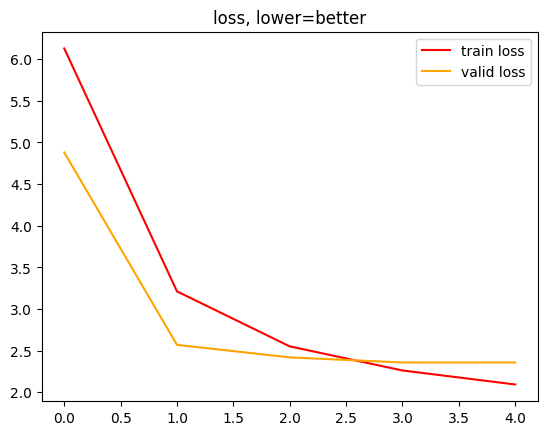

In [29]:
plt.plot(trainer.metrics['train_loss'],color='red',label='train loss')
plt.plot(trainer.metrics['val_loss'],color='orange',label='valid loss')
plt.title('loss, lower=better')
plt.legend()
plt.show()

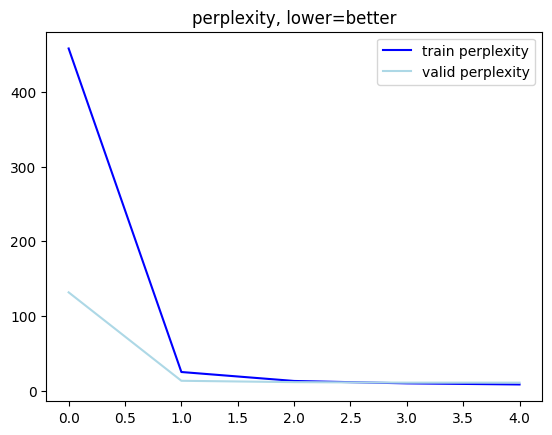

In [30]:
plt.plot(trainer.metrics['train_perplexity'],color='blue',label='train perplexity')
plt.plot(trainer.metrics['val_perplexity'],color='lightblue',label='valid perplexity')
plt.title('perplexity, lower=better')
plt.legend()
plt.show()

In [31]:
trainer.load_best_model()

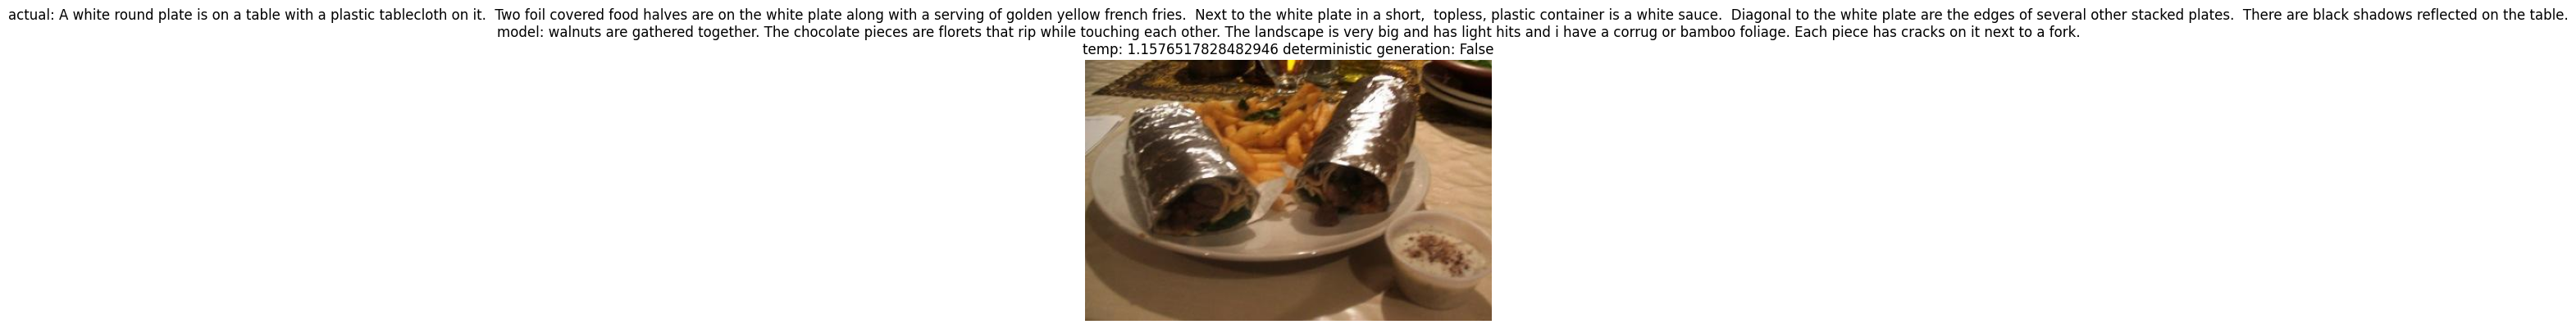

In [35]:
test_img=r"/content/drive/MyDrive/Colab Notebooks/Data/IC_dataset/train/train_1.jpg"
test_caption="A white round plate is on a table with a plastic tablecloth on it.  Two foil covered food halves are on the white plate along with a serving of golden yellow french fries.  Next to the white plate in a short,  topless, plastic container is a white sauce.  Diagonal to the white plate are the edges of several other stacked plates.  There are black shadows reflected on the table."
for i in range(1):
    det = False
    # test = val_df.sample(n=1).values[0]
    # test_img, test_caption = test[0],test[1]
    plt.imshow(Image.open(test_img).convert('RGB'))
    t = np.random.uniform(0.5,1.5)
    if i > 40:
        det = True
    gen_caption = trainer.generate_caption(test_img,temperature=t,deterministic=det)
    plt.title(f"actual: {test_caption}\nmodel: {gen_caption}\ntemp: {t} deterministic generation: {det}")
    plt.axis('off')
    plt.show()